In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import pickle
import cv2
from google.colab.patches import cv2_imshow
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
# Check GPU is available
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# set random seed to be used all over
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
#os.environ['TF_DETERMINISTIC_OPS'] = '1' #deterministic behavior in TensorFlow operations.
tf.keras.utils.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,log_device_placement =True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [5]:
# Path to the directory containing the your project info (Change to your location)
PROJECT_ROOT_DIR = '/content/drive/MyDrive/'

# Path to the directory containing the dataset
# DOWNLOAD BUSI dataset here: https://scholar.cu.edu.eg/?q=afahmy/pages/dataset
DATA_DIR = 'Dataset_BUSI_with_GT/'

In [6]:
# Funciton for loading the dataset
# reference: https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

def load_image():
  # initialize the data and labels for each class
  data = []
  labels = []

  data_aside = []
  labels_aside = []

  benign_data = []
  benign_labels = []

  malignant_data = []
  malignant_labels = []

  normal_data = []
  normal_labels = []

  # load benign image
  for i in range(1,438):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'benign/' + 'benign (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    benign_data.append(image)
    # extract the class label from the image folder
    benign_labels.append('benign')

  for i in range(0,437):
      data.append(benign_data[i])
      labels.append(benign_labels[i])

  # load malignant image
  for i in range(1,211):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'malignant/' + 'malignant (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    malignant_data.append(image)
    # extract the class label from the image folder
    malignant_labels.append('malignant')

  for i in range(0,210):
      data.append(malignant_data[i])
      labels.append(malignant_labels[i])

  # load normal image
  for i in range(1,134):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'normal/' + 'normal (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    normal_data.append(image)
    # extract the class label from the image folder
    normal_labels.append('normal')

  for i in range(0,133):
      data.append(normal_data[i])
      labels.append(normal_labels[i])

  return data, labels
# Function for image preprocessing
def preprocess(data,labels):
  # Save training and test image to numpy, Scale image features to be in [0, 1]
  data = np.array(data, dtype = np.float32) / 255.0
  # Save labels to numpy encode label to integer catergory 0 = 'benign', 1 = 'malignant', 2 = 'normal'
  labels = np.array(labels)
  new_label_encoder = preprocessing.LabelEncoder()
  new_label_encoder.fit(labels)
  targets = new_label_encoder.transform(labels)

  return data, targets

In [7]:
# Load the BUSI images and labels
# This will take time (my time was around 12 min)
data, labels = load_image()
data, labels = preprocess(data,labels)

# split data into 80% train and 20% test, shuffle the data with
(imgs_train, imgs_test, labels_train, labels_test) = train_test_split(data, labels, test_size = 0.2, random_state=SEED, shuffle = True)
# split data into 60% train data and 20% validation data
(imgs_train, imgs_val, labels_train, labels_val) = train_test_split(imgs_train, labels_train, test_size = 0.2, random_state=SEED, shuffle = True)

In [8]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))

Images train shape: (499, 224, 224, 3) - Labels train shape: (499,)
Images validation shape: (125, 224, 224, 3) - Labels validation shape: (125,)
Images test shape: (156, 224, 224, 3) - Labels test shape: (156,)


In [9]:
NUM_LABELS = 3                             # Number of labels
BATCH_SIZE = 16                             # Size of batch
HEIGHT = 224                                 # Height of input image
WIDTH = 224                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 3                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 100                             # Number of epoch to train
LR = 0.0001                                 # Learning rate

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

In [10]:
from tensorflow import keras
labels_train = keras.utils.to_categorical(labels_train, NUM_LABELS)
labels_test = keras.utils.to_categorical(labels_test, NUM_LABELS)
labels_val = keras.utils.to_categorical(labels_val, NUM_LABELS)

# **Task 1(a)**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_cnn_model():
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Output Layer
    model.add(Dense(NUM_LABELS, activation='softmax'))

    return model

In [13]:
# Create the CNN model
model = create_cnn_model()

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=LR)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the CNN model
history = model.fit(
    imgs_train,
    labels_train,
    validation_data=(imgs_val, labels_val),
    epochs=NUM_EPOCH,
    batch_size=BATCH_SIZE
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.5068 - loss: 1.0141 - val_accuracy: 0.5840 - val_loss: 1.0248
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5537 - loss: 0.9880 - val_accuracy: 0.6320 - val_loss: 0.8381
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6058 - loss: 0.8065 - val_accuracy: 0.6240 - val_loss: 0.8670
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6733 - loss: 0.7194 - val_accuracy: 0.6240 - val_loss: 0.8914
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7083 - loss: 0.6242 - val_accuracy: 0.6320 - val_loss: 0.8746
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7850 - loss: 0.5072 - val_accuracy: 0.6720 - val_loss: 0.8328
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8574 - loss: 0.3950 - val_accuracy: 0.7040 - val_loss: 0.7287
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8835 - loss: 0.3127 - val_accuracy: 

In [15]:
# Evaluate on the training set
train_loss, train_acc = model.evaluate(imgs_train, labels_train, verbose=0)
print(f'Train Accuracy: {train_acc * 100:.2f}%')

# Evaluate on the validation set
val_loss, val_acc = model.evaluate(imgs_val, labels_val, verbose=0)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(imgs_test, labels_test, verbose=0)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Train Accuracy: 100.00%
Validation Accuracy: 69.60%
Test Accuracy: 74.36%


# **Task 1(b)**

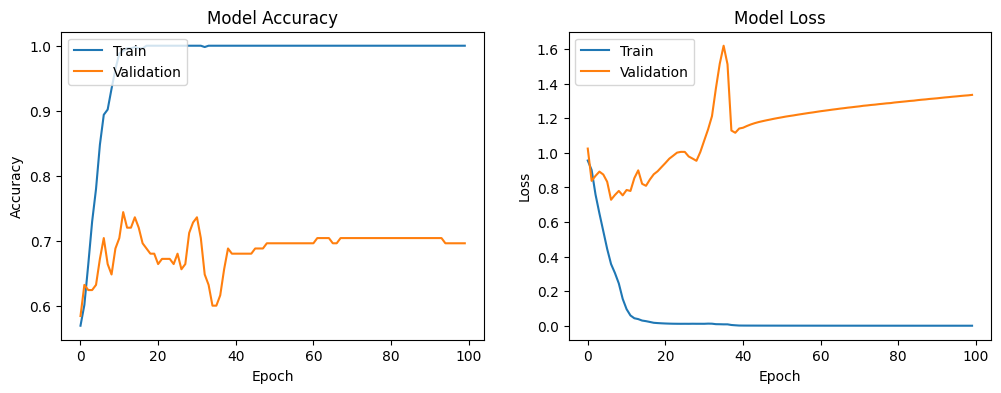

In [16]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plot
plt.show()

# **Task 2(a)**

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 model with ImageNet weights, excluding top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Add custom classification layers on top of the ResNet50 base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer with 1024 units
x = Dropout(0.5)(x) # Dropout to prevent overfitting
output_layer = Dense(NUM_LABELS, activation='softmax')(x)  # Output layer with softmax for 3 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze the layers of ResNet50 to fine-tune the new layers first
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Apply data augmentation with additional techniques
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model with augmented data
history = model.fit(
    data_gen.flow(imgs_train, labels_train, batch_size=16),
    validation_data=(imgs_val, labels_val),
    epochs=100,
    batch_size=16,
    shuffle=True
)

# Unfreeze the base model layers for further fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Fine-tune the entire model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    data_gen.flow(imgs_train, labels_train, batch_size=16),
    validation_data=(imgs_val, labels_val),
    epochs=100,
    batch_size=16,
    shuffle=True
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 674ms/step - accuracy: 0.4055 - loss: 1.2903 - val_accuracy: 0.5840 - val_loss: 0.9544
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.5138 - loss: 1.1230 - val_accuracy: 0.5840 - val_loss: 0.9676
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.4982 - loss: 1.1421 - val_accuracy: 0.5840 - val_loss: 1.0046
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.4599 - loss: 1.2160 - val_accuracy: 0.5840 - val_loss: 0.9622
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.4976 - loss: 1.0773 - val_accuracy: 0.5840 - val_loss: 0.9630
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.4964 - loss: 1.1449 - val_accuracy: 0.5840 - val_loss: 0.9909
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.5354 - loss: 1.0677 - val_accuracy: 0.5840 - val_loss: 0.9338
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.5014 - loss: 1.0827 - val_accuracy: 0

In [19]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(imgs_train, labels_train, verbose=1)
print(f"Training set accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(imgs_val, labels_val, verbose=1)
print(f"Validation set accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(imgs_test, labels_test, verbose=1)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.9968 - loss: 0.0080
Training set accuracy: 99.00%
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8676 - loss: 0.7052
Validation set accuracy: 87.20%
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8959 - loss: 0.9941
Test set accuracy: 89.74%


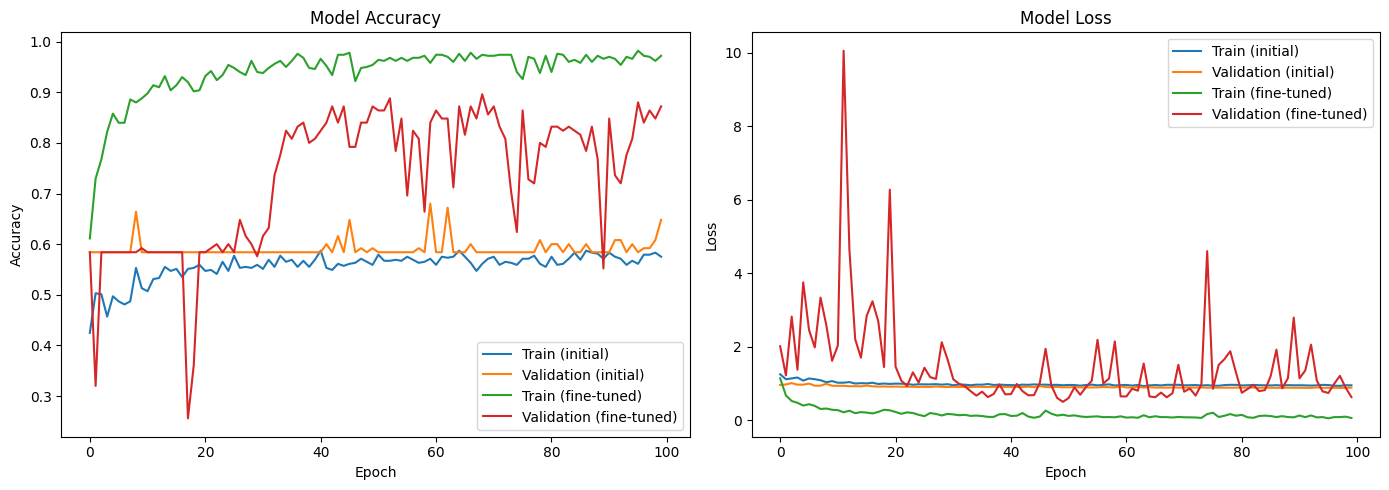

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train (initial)', 'Validation (initial)', 'Train (fine-tuned)', 'Validation (fine-tuned)'], loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train (initial)', 'Validation (initial)', 'Train (fine-tuned)', 'Validation (fine-tuned)'], loc='best')

plt.tight_layout()
plt.show()

# **Task 3(a)**

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Load pre-trained ResNet50 model with ImageNet weights, excluding top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Add custom classification layers on top of the ResNet50 base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
output_layer = Dense(NUM_LABELS, activation='softmax')(x)  # Output layer with softmax for classification

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze the layers of ResNet50 to fine-tune the new layers first
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Apply data augmentation with additional techniques
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model with augmented data
history = model.fit(
    data_gen.flow(imgs_train, labels_train, batch_size=16),
    validation_data=(imgs_val, labels_val),
    epochs=100,
    batch_size=16,
    shuffle=True
)

# Unfreeze the base model layers for further fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Fine-tune the entire model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    data_gen.flow(imgs_train, labels_train, batch_size=16),
    validation_data=(imgs_val, labels_val),
    epochs=100,
    batch_size=16,
    shuffle=True
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - accuracy: 0.4021 - loss: 14.2236 - val_accuracy: 0.5840 - val_loss: 12.0942
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.5221 - loss: 11.6674 - val_accuracy: 0.5840 - val_loss: 10.0102
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.4657 - loss: 9.7822 - val_accuracy: 0.5840 - val_loss: 8.2752
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.5151 - loss: 8.0296 - val_accuracy: 0.5840 - val_loss: 6.8736
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.5098 - loss: 6.6815 - val_accuracy: 0.5840 - val_loss: 5.7584
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.5262 - loss: 5.6462 - val_accuracy: 0.5840 - val_loss: 4.8258
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.4818 - loss: 4.7673 - val_accuracy: 0.5840 - val_loss: 4.1044
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.5811 - loss: 4.0153 - 

In [22]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(imgs_train, labels_train, verbose=1)
print(f"Training set accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(imgs_val, labels_val, verbose=1)
print(f"Validation set accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(imgs_test, labels_test, verbose=1)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.9811 - loss: 0.0994
Training set accuracy: 97.60%
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 0.8138 - loss: 1.1920
Validation set accuracy: 80.80%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.8571 - loss: 0.7084
Test set accuracy: 85.26%


# **Task 3(b)**

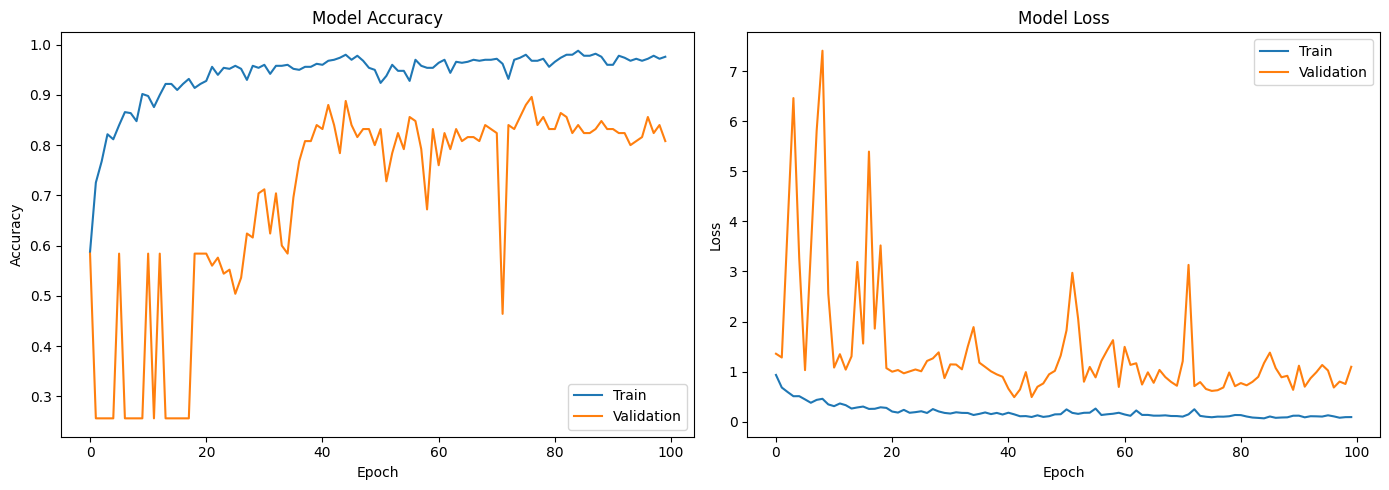

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values for Task 3
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='best')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='best')

plt.tight_layout()
plt.show()